# Truncated SVD

In this notebook we explore the truncated svd solution technique using the pilot point parameterization jacobian matrix

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import flopy
import pyemu


In [2]:
t_d = "template_history"
m_d = "master_glm_run"

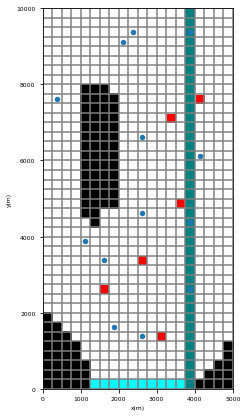

In [3]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d,check=False,forgive=False)
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.PlotMapView(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
mm.plot_bc("GHB")
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

Just a reminder that we are still doing groundwater modeling!!!

Load the control file:

In [4]:
pst = pyemu.Pst(os.path.join("master_glm","freyberg_pp.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_prsity6,cn_prsity6,log,1,0,0.176091,-0.30103,0.11928
cn_prsity7,cn_prsity7,log,1,0,0.176091,-0.30103,0.11928
...,...,...,...,...,...,...,...
pp_vka0,pp_vka0,fixed,32,1,10,0.1,2.475
pp_vka1,pp_vka1,log,32,0,1,-1,0.5
pp_vka2,pp_vka2,fixed,32,1,10,0.1,2.475
welflux,welflux,log,25,0,1,-1,0.5


Load Jacobian matrix:

In [5]:
jco = pyemu.Jco.from_binary(os.path.join("master_glm","freyberg_pp.jcb"))
jco.shape

(7272, 569)

use only the non-zero-weighted obs

In [6]:
jco = jco.get(pst.nnz_obs_names,pst.adj_par_names)
jco.shape

(350, 569)

work up the components for the gauss-newton alg:

the "cofactor" matrix is the inverse of the observation variances:

In [7]:
obscov = pyemu.Cov.from_observation_data(pst).get(pst.nnz_obs_names)
obscov.shape

(350, 350)

In [8]:
q = obscov.inv

form the weighted "normal" matrix.  The multiplying across the cofactor matrix, we dampen rows on the jacobian that corespond to highly-uncertain observations (we dont want to change parameters much for uncertain observations...)

In [9]:
jtqj = jco.T * q * jco
jtqj.shape

(569, 569)

The normal matrix can also be thought of as a covariance matrix:

In [10]:
c = pyemu.Cov(x=jtqj.x.copy(),names=pst.adj_par_names)
c = c.to_pearson()

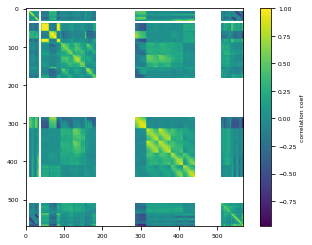

In [11]:
cb = plt.imshow(c.x)
cb = plt.colorbar(cb)
cb.set_label("correlation coef")

Lots of correlation!  that's not a good sign for hoping to invert this matrix:

In [12]:
try:
    jtqj.inv
except Exception as e:
    print("frowny face: "+str(e))

frowny face: Singular matrix


### SVD to the rescue!

so we have to invert this matrix to continue with the parameter estimation process - this is where (truncated) SVD comes in.  Just a refresher of the SVD components (see the SVD_1 notebook for more background).
First let's examine the singular value matrix (`s`)

In [13]:
s = jtqj.s

Text(0, 0.5, '$log_{10}$ singular value')

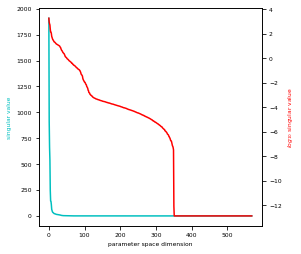

In [14]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(s.x,color="c")
axt = plt.twinx(ax)
axt.plot(np.log10(s.x),color="r")
ax.set_xlabel("parameter space dimension")
ax.set_ylabel("singular value",color='c')
axt.set_ylabel("$log_{10}$ singular value",color="r")

We see that even with 350 observations, there is significantly less information content because there is non-unique information in those 350 observations.  

In [15]:
v = jtqj.v
v.shape

(569, 569)

In [16]:
maxsing = 3

In [17]:
u1,s1,v1 = jtqj.pseudo_inv_components(maxsing=maxsing)

In [18]:
u1.shape,s1.shape,v1.shape

((569, 3), (3, 3), (569, 3))

So we see that the singular components were "truncated" at  10 columns for `u` and `v` and `s` had both rows and columns truncated

reconstruct the normal matrix using the truncated SVD components

In [19]:
jtqj_t = u1 * s1 * v1.T

In [20]:
jtqj_t.shape

(569, 569)

The original normal matrix as a correlation coef matrix

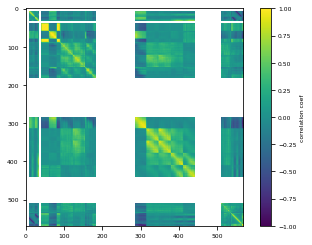

In [21]:
c = pyemu.Cov(x=jtqj.x.copy(),names=pst.adj_par_names)
c = c.to_pearson()
cb = plt.imshow(c.x,vmax=1,vmin=-1)
cb = plt.colorbar(cb)
cb.set_label("correlation coef")

The truncated normal matrix as a correlation coef matrix

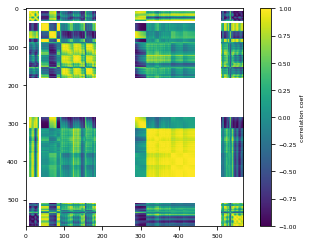

In [22]:
c = pyemu.Cov(x=jtqj_t.x.copy(),names=pst.adj_par_names)
c = c.to_pearson()
cb = plt.imshow(c.x,vmax=1,vmin=-1)
cb = plt.colorbar(cb)
cb.set_label("correlation coef")

Pretty similar...

## Exploring how truncation effects the solution process

Let's solve the gauss-netwon equation using the truncated svd inverse of the normal matrix and explore how changing the truncation level effects the solution:

In [23]:
maxsing = 350 #the number of non-zero-weighted observations
u1,s1,v1 = jtqj.pseudo_inv_components(maxsing=maxsing,eigthresh=1e-30)

In [24]:
s1_inv = s1.inv

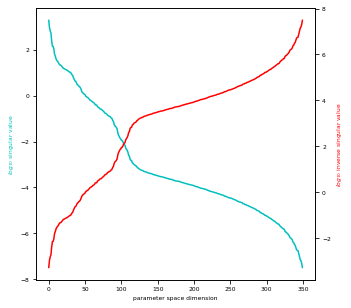

In [25]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.log10(np.diag(s1.x)),color='c')
axt = plt.twinx(ax)
axt.plot(np.log10(np.diag(s1_inv.x)),color='r')
ax.set_ylabel("$log_{10}$ singular value",color="c")
axt.set_ylabel("$log_{10}$ inverse singular value",color="r")
_ = ax.set_xlabel("parameter space dimension")

So as we use more and more singular components, we include smaller and smaller singular values in the solution (the cyan curve), which correspond to "higher frequency" parameter and observation components - remember the image-based examples with the SVD_1 notebook.   But when we invert the singular value matrix to form a pseudo inverese of the normal matrix, those small singluar values become very large values, essentially amplifying the high frequencey components in the solution process #sad.

Form the inverse of the normal matrix

In [26]:
jtqj_inv = v1 * s1_inv * u1.T

Get the residual vector

In [27]:
res_vec = pst.res.loc[pst.nnz_obs_names,"residual"].values
res_vec.shape

(350,)

Solve for the inverted parameter values using gauss-newton formula (non-iterative...):

In [28]:
p_inv = jtqj_inv * jco.T * q * res_vec

In [29]:
p_inv.shape,np.abs(p_inv.x).max()

((1, 569), 5792.745793693737)

Let's explore how changing the truncation point effects the resulting inverted parameter values - we will only examine the magnitude of parameter changes...

In [30]:
maxsing = 10
u1,s1,v1 = jtqj.pseudo_inv_components(maxsing=maxsing,eigthresh=1e-30)
jtqj_inv = v1 * s1.inv * u1.T
p_inv = jtqj_inv * jco.T * q * res_vec
print("max abs change",np.abs(p_inv.x).max())
print("mean abs change",np.abs(p_inv.x).mean())

max abs change 0.847484972516363
mean abs change 0.023909637292079376


So we see that if we use the full compliment of singular components (350 = nnz obs), we get crazy parameter changes.  yikes!  This implies that our inverse problem is highly sensitive to small changes in the residuals...but using 10-20 results in more reasonable changes.  

To further drive this point home, lets compare how sensitive the solution is to "expected" noise (that is, the noise we expressed through the observation weights)

Generate a single observation values plus noise realization and form a new residual vector

In [31]:
np.random.seed = 1111
oe = pyemu.ObservationEnsemble.from_gaussian_draw(pst,num_reals=1)
noisy_res_vec = oe.loc[oe.index[0],pst.nnz_obs_names] - pst.res.loc[pst.nnz_obs_names,"modelled"]
noisy_res_vec = noisy_res_vec.values

In [32]:
maxsing = 10
u1,s1,v1 = jtqj.pseudo_inv_components(maxsing=maxsing,eigthresh=1e-30)
jtqj_inv = v1 * s1.inv * u1.T
p_inv = jtqj_inv * jco.T * q * res_vec
p_inv_noisy = jtqj_inv * jco.T * q * noisy_res_vec

print("max abs change",np.abs(p_inv.x - p_inv_noisy.x).max())
print("mean abs change",np.abs(p_inv.x - p_inv_noisy.x).mean())

max abs change 0.07445142803152771
mean abs change 0.0027654698200733252


Again, we see that trying to use all the 350 singular components is dangerous - the resulting inverse problem is highly sensitive to noise.  But using a more convervative pseudo inverse stabilizes the problem.  #winning

## "super parameters"

seeing as how just a few columns of `v` are being used to invert for the parameter values, that's a high cost to fill the full jco each iteration.  So what if we fill the jco once, do the svd, and then construct a new inverse problem based on estimating multipliers on the columns of `v`: boom! super parameters.  So `SVD-Assist` is a way to decrease the computational burden of high-dimensional inverse problems while still using an optimal and compact representation of high-dimensional parameter space.

## Null-space Monte Carlo

Null-space monte carlo also takes advantage of the orthonormal basis in parameter space that SVD yields.  If we truncated at 10, the first 10 columns of `V` represent the parameter combinations (or "loading factors") that are informed by the observations (adjusted).  That means the remaining columns of `V` (from 10 to 569) are not informed by the observations.  This is the "null space", which, by definition, means we can put any values in those last columns of `V` and not change the fit to the observations.  So what if we adjust only the parameter components that are in those last 559 columns of `V` in random ways to explore posterior uncertainty: boom!  null space monte carlo.  